In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import pickle as pkl

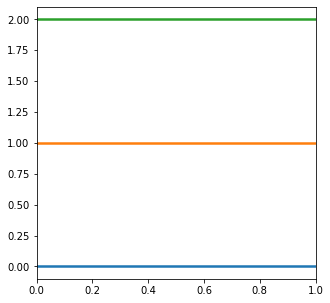

In [2]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#new_cmap = ['#1F78B4','#FB9A99','#E31A1C']
new_cmap = ['tab:blue','tab:orange','tab:green']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,3))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [3]:
systems = ['2PHES_150mMNaCl', 'TYR_PHE_150mMNaCl', '2TYRS_150mMNaCl', 'BUTYLAMMONIUM_ACETATE', 'GUANIDINE_ACETATE']
ffmods = ['Unmodified', 'PW', 'PP']

systems_plotname_alt = {'2PHES_150mMNaCl':'Phe-Phe',
                    'TYR_PHE_150mMNaCl':'Tyr-Phe',
                    '2TYRS_150mMNaCl':'Tyr-Tyr',
                    'BUTYLAMMONIUM_ACETATE':'Butylammonium-Acetate',
                    'GUANIDINE_ACETATE':'Guanidine-Acetate'}

systems_plotname = {'2PHES_150mMNaCl':'Phe-Phe',
                    'TYR_PHE_150mMNaCl':'Tyr-Phe',
                    '2TYRS_150mMNaCl':'Tyr-Tyr',
                    'BUTYLAMMONIUM_ACETATE':'Lys-Asp',
                    'GUANIDINE_ACETATE':'Arg-Asp'}

recalculate = False

In [4]:
#Functions for saving and loading pickle files
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

# PMF stuff

In [7]:
if recalculate == True:
    for system in systems:
        COMdist_hist_vs_sim = {}
        for ffmod in ffmods:
            print(f'Starting {system} {ffmod}')

            time, COMdist = np.genfromtxt(f'data/COMdist_{system}_{ffmod}.xvg', skip_header=17, usecols=(0,1), unpack=True)
            print('Loaded data')

            #Plot PDF of COM distance
            fig = plt.figure(figsize=(5,5)) 
            plt.title(f'{system} {ffmod}')
            #KDE
            kde_x = np.linspace( np.amin(COMdist)*0.9, np.amax(COMdist)*1.1, num = 50 )
            kde_y = stats.gaussian_kde(COMdist, bw_method = "silverman").evaluate(kde_x)
            print('Finished kde')

            #Plot
            plt.hist(COMdist, density=True, bins=50)
            plt.plot(kde_x, kde_y, '-', linewidth=2, c='black')

            plt.xlabel('COM dist (nm)')
            plt.ylabel('PDF')

            '''
            #Plot PMF by getting dG from KDE on histogram of COMdists 
            G_kde = -np.log(kde_y)
            print('Finished dG calculation from kde')

            fig = plt.figure(figsize=(5,5))
            plt.title(f'{system} {ffmod}')
            plt.plot(kde_x, G_kde)

            plt.xlabel('COM dist (nm)')
            plt.ylabel('ΔG (kBT)')
            '''

            #Plot PMF by getting dG from directly from histogram

            #Make histogram of COM distance
            COMdist_hist_y, COMdist_hist_edges = np.histogram(COMdist, bins=100, density=True)
            COMdist_hist_x = []
            for i,edge in enumerate(COMdist_hist_edges[:-1]):
                bin_center = np.average([COMdist_hist_edges[i+1], edge])
                COMdist_hist_x.append(bin_center)
            COMdist_hist_x=np.array(COMdist_hist_x)
            print('Finished histogram')

            COMdist_hist_vs_sim[f'{system}_{ffmod}'] = [COMdist_hist_x, COMdist_hist_y]

        save_pickle(f'pickles/COMdist_hist_{system}.pkl', COMdist_hist_vs_sim)


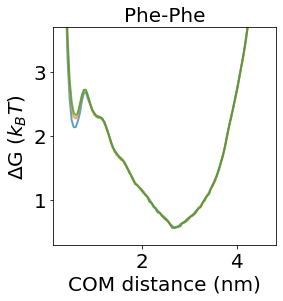

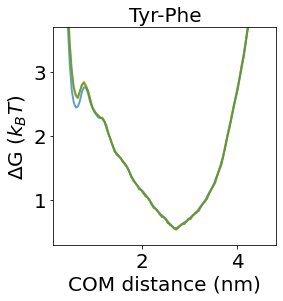

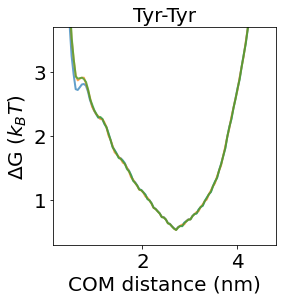

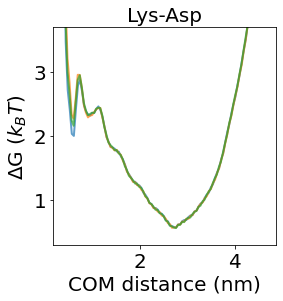

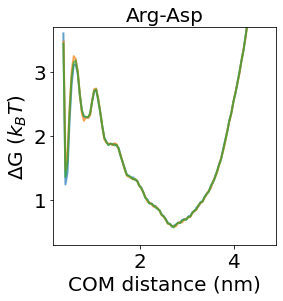

In [9]:
for system in systems:
    COMdist_hist_vs_sim = load_pickle(f'pickles/COMdist_hist_{system}.pkl')

    fig = plt.figure(figsize=(4,4))
    
    for ffmod in ffmods:
        COMdist_hist = COMdist_hist_vs_sim[f'{system}_{ffmod}']
        #Calculate free energy (in kBT) along COM distance as -ln(P)
        G = -np.log(COMdist_hist[1])

        #Plot PMF
        plt.plot(COMdist_hist[0], G, lw=2, alpha=0.7)
    
    plt.title(systems_plotname[system], fontsize=20)
    plt.xlabel('COM distance (nm)', fontsize=20)
    plt.ylabel('ΔG ($k_{B}T$)', fontsize=20)
    plt.tick_params(labelsize=20)
    
    plt.ylim(0.3,3.7)
    
    #plt.xlim(0.3,1.0)
    
    fig.savefig(f'../figures/{system}_PMF.png', bbox_inches='tight', pad_inches=1, dpi=400)
    fig.savefig(f'../figures/{system}_PMF.pdf', bbox_inches='tight', pad_inches=1, dpi=400)